# Problem 1 - Josh

Read Shannon’s 1948 paper ’A Mathematical Theory of Communication’.  
Focus on pages 1-19 (up to Part II), the remaining part is more relevant for communication.
https://people.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf

*Q: Summarize what you learned briefly (e.g. half a page).*

After reading Shannon’s 1948 paper ‘A Mathematical Theory of Communication I learned a
great deal about communication and the math that goes along with it. One topic I learned was
the different types of information sources that exist to produce a message to be communicated.
For example, there exist messages that contain two or more functions of time which are
apparent in “three-dimensional” sound transmission. Another information source that is notable
is messages that contain several functions of several variables such as in color television in
which the message contains three functions defined in a three-dimensional continuum. With all
of these messages needing to be sent over a channel, the capacity of a channel becomes
useful in knowing how much a particular channel can transmit. 
Using the equation

$$C = \lim_{T \to \inf}\frac{logN(T)}{T}$$
, one can get the capacity of a specific channel. Another fact I learned
about messages is that some message sequences possess restrictions on what can be sent in
what order. More specifically, only a certain set of symbols can be transmitted and once this
symbol is sent, the state changes to a new state depending on the old state and the particular
symbol that has been transmitted. An example of this is the telegraph case where there are two
states that depend on whether a space was the last symbol transmitted. If the space condition
is satisfied, only a dot can be sent next and the state always changes. Otherwise, any symbol
can be transmitted and the current state will only change if a space is sent, else it stays the
same. One last thing I learned that I found particularly interesting was that messages are
encoded based on the likelihood of a certain symbol in a given sequence. For example in
English, the letter E occurs much more likely than the letter Q. By knowing these trends, we can
use a Markov Chain to represent the probability of each letter in a message sequence. Using
this information, we are able to decide the proper way to encode the message for transmission.

# Problem 2 - Jackson  

ICML is a top research conference in Machine learning. Scrape all the pdfs of all ICML 2017 papers from http://proceedings.mlr.press/v70/.
1. What are the top 10 common words in the ICML papers?
2. Let Zbe a randomly selected word in a randomly selected ICML paper. Estimate the entropy
of Z.
3. Synthesize a random paragraph using the marginal distribution over words.
4. (Extra credit) Synthesize a random paragraph using an n-gram model on words. Synthesize
a random paragraph using any model you want. Top five synthesized text paragraphs win
bonus (+30 points).

In [145]:
# Scraper
from bs4 import BeautifulSoup as bs
from tqdm import tqdm
from random import random
import pandas as pd
import numpy as np
import requests
import logging
import fitz
import os

def scrape(dump_folder, source):
    if dump_folder[-1] != '/':
        dump_folder += '/'
    #Create folder to dump into
    if not os.path.isdir(dump_folder):
        os.mkdir(dump_folder)

    #Set up logging
    f = open(f'{dump_folder}log.txt', 'w') #Open the file if its not already opened
    f.close()
    logging.basicConfig(level=logging.INFO, filename=f'{dump_folder}log.txt')
    
    #Get list of links
    html = requests.get(source)
    soup = bs(html.content, 'html.parser')
    links = soup.findAll('a')

    #Scrape all PDFs
    names = []
    for l in links:
        if l.decode_contents() == 'Download PDF' or l.decode_contents() == 'Supplementary PDF':
            src = l.get('href').replace('ı', 'i') # Fix small error in one of the scraped links
            fname = src[src.rindex('/')+1:]
            if fname in names:
                logging.CRITICAL(f'OVERWRITING FILE WITH NAME {fname}')
            names.append(fname)
            logging.info(f'Scraping pdf from {src} into {fname}')

            pdf = requests.get(src)
            with open(f'{dump_folder}{fname}', 'wb') as f:
                f.write(pdf.content)

def parse_pdf(fp):
    df = pd.DataFrame(columns=['word', 'prev'])
    pdf = fitz.open(fp)
    for page in pdf:
        _blocks = pdf[0].get_text_blocks()
        blocks = []
        for b in _blocks:
            if b[-1] != 1:
                blocks.append(b)

        #Create 2D array of words by block
        data = [x[4].replace('. ', ' . ').split() +['\end'] for x in blocks]
        if data == []:
            continue
        mlen = max([len(d) for d in data])
        data = [d + ['' for i in range(mlen - len(d) + 1)] for d in data]

        #Create array of previous words by block
        words = np.array(data)
        prev = np.roll(words, 1, axis=1)
        prev[:, 0] = '\start'

        words = words.flatten()
        prev = prev.flatten()

        df = pd.concat([df, pd.DataFrame(data = np.column_stack([words, prev]), columns=['word', 'prev'])])

    return df.drop(df[(df['word']=='') | (df['prev']=='')].index)


def parse_pdfs(dump_folder):
    df = pd.DataFrame(columns=['word', 'prev'])
    for fp in tqdm(os.listdir(dump_folder)):
        if not fp.endswith('pdf'):
            continue #Only process PDFs
        df = pd.concat([df, parse_pdf(dump_folder+fp)])

    df['count'] = 1
    df = pd.pivot_table(df, values='count', index=['prev', 'word'], aggfunc=np.sum)
    df = df.reset_index(level=1)
    df = df[(df.index.str.match(r'^[\\a-zA-Z\.]+$')) & (df['word'].str.match(r'^[\\a-zA-Z\.]+$'))]
    df['total'] = df.groupby(by='prev').transform('sum')['count'].astype(int)
    df['percent'] = df['count'] / df['total']
    df['cumsum'] = df.groupby(by='prev').transform('cumsum')['percent'].astype(float)

    return df

def predict(df, prev_word):
    """
    Given a previous word, and a marginal distribution dataframe, predict the word that follows it
    """
    p = random()
    words = df.loc[prev_word]
    if type(words) == pd.Series:
        return words['word']
    words = words[words['cumsum'] > p]
    return words.iloc[0]['word']
    

    

def synthesize_text(use_stored_data= True, df_fp='./distir.csv', save=True, source='http://proceedings.mlr.press/v70/', dump_folder = './scraped/', scrape_data=True):
    """If stored data exists, use it
    Otherwise scrape and process
    

    Then iteratively predict what word comes next"""

    # Scrape if necessary
    if not (use_stored_data and os.path.exists(df_fp)):
        if scrape_data:
            print('Scraping...', end='')
            scrape(dump_folder, source)
            print('Done!')
        df = parse_pdfs(dump_folder)
        
        #Save if wanted
        if save:
            df.to_csv(df_fp)
    else:
        df = pd.read_csv(df_fp, index_col=0)

    # Iteratively Synthesize Text
    words = ['\start']
    while words[-1] != '\end':
        words += [predict(df, words[-1])]
        
    return (' '.join(words[1:-1])).replace(' . ', '. ')

def top_words(df, n=10):
    return list(df.groupby(by='word')['count'].sum().sort_values(ascending=False).head(n).index)

def entropy(_df, word=None):
    if word is None:
        word = _df['word'].sample(1).values[0]

    df = _df[_df['word'] == word]

    return word, -1 * (np.sum(df['percent'] * np.log(df['percent'])/np.log(2)))

In [115]:
#top 10 words
df = pd.read_csv('./distir.csv')
top_words(df, 10)

['the', 'of', '.', 'a', 'to', '\\end', 'is', 'and', 'in', 'that']

In [152]:
entropy(df)

('implement', 0.1260897249795341)

In [155]:
synthesize_text()

'Z is still not have too sensitive to quadratically in the learnable embeddings separately by a good prediction As its evolution over binary vectors. These include the amount of the system. Exact solutions to the full history and useful and was naturally generate sparse generalized WNN by combining the neural architectures despite its performance of Thm. We note that leads to estimate the feasible region P. . Fix a typical case of the c.d.f. Correspondence'

# Takeaways and synthesized text

> C \\\\ S is the input perturbation of about individuals

> Z is still not have too sensitive to quadratically in the learnable embeddings separately by a good prediction As its evolution over binary vectors. These include the amount of the system. Exact solutions to the full history and useful and was naturally generate sparse generalized WNN by combining the neural architectures despite its performance of Thm. We note that leads to estimate the feasible region P. . Fix a typical case of the c.d.f. Correspondence

Above are examples of text that was produced using only the marginal distribution of words seen in the scraped PDFs, however it is not a very good approximation of human sentences.
This is due to the fact that words are not constructed in the context of the previously seen word, but rather all words in the sentence and paragraph prior to it.

An n-gram model takes the same concept but expands to be trained on the context of the n-previous words, with a higher n leading to much better text generation.
This still has its limitations however, as even a very large corpus does not have enough data to fully capture the range of possible human speech, so recurrent neural networks trained on tokenized text is a better next step.


# Problem 3 - Jhanvi
Continue building your toolbox on Kaggle. Work on submissions for the same competition
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/
1. What is the best Kaggle forum post that you found? Briefly describe what you learned from
it.
2. What is the best public leader board (LB) score you can achieve? Describe your approach.
3. Submit a model that is definitely overfitting and a model that is definitely underfitting.
Overfitting means that your training error is much smaller compared to your test error (and
LB score). Underfitting means that your model is too simple and even the training error is
very large (and so will the test error). You can experiment with depth of decision trees in
random forests or XGBoost classifiers as the metric of complexity for your models, or any
other family of models you want.

Question 1: A forum post I found insightful was "Top 3% housing: 8 Insights, 4 Learnings and 2 Questions (after 50+ hours)". It detailed the importance of feature engineering and data cleaning prior to running models. It also talked through the benefit of blended models with different weights versus stacked models. Another forum post that was beneficial in understanding how to approach data was Comprehensive data exploration with Python. A Detailed Regression Guide with Python highlighted the different statistical and probabilities formulas that inform why and how models work. A non-Kaggle post that explained different ways to use XGBoost was from TowardsDataScience.

Question 2: The best public leaderboard score I got was 0.12078. This was achieved using an equally weighted blended model using Lasso and XGBoost. The optimal parameters for the Lasso model were calculated through the built-in cross-validation function, while a GridSearch was used for tuning the XGBoost hyper-parameters.

Question 3: To submit overfit and underfit models, I tweaked the alpha parameter of the ridge regression model. By first plotting the rmse and corresponding alphas, I identified alpha values that were not well suited to the data - below 10 to overfit and include too much rigidity in the model and much above 10 to underfit.


Note: The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

The best rsme for the ridge regression is 0.1273373466867076


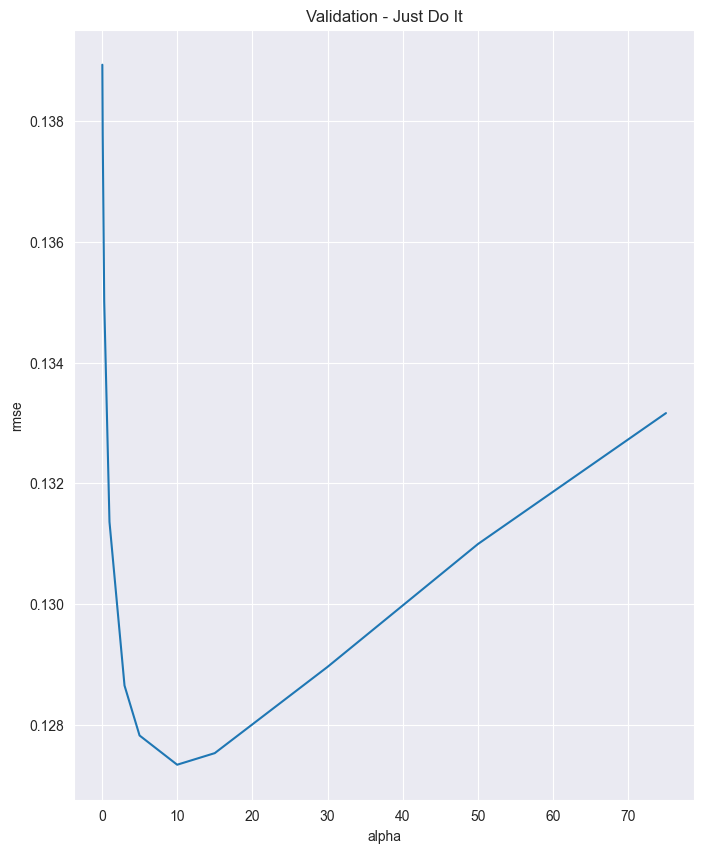

In [ ]:
# Imports
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

train = pd.read_csv("/Users/jhanvig/datalab/files/train.csv")
test = pd.read_csv("/Users/jhanvig/datalab/files/test.csv")

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

# Since data, specifically SalePrice is skewed, we need to make it normal as models require normal distributions ideally
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data = pd.get_dummies(all_data)
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

# putting data in matrix form
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

# The RMSE (training error) calculator function
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

#Ridge
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean()
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")


print("The best rsme for the ridge regression is {}".format(cv_ridge.min()))
model_ridge = Ridge(alpha=1)
model_ridge.fit(X_train, y)
# To overfit would be to choose too small an alpha, to underfit would be to choose too high an alpha >> consider these changes for ridge, lasso, and xgboost models

# Lasso
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
print("The best rsme for the lasso regression is {}".format(rmse_cv(model_lasso).mean()))

coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

##### perhaps bootstrap here

imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
mpl.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

print("Fitting 5 folds for each of 54 candidates, totalling 270 fits \n Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000} \n Lowest RMSE:  0.12009122458887428")

# XgBoost
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

model_xgb = xgb.XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.05, colsample_bytree=0.3) #the params were tuned using GridSearch
model_xgb.fit(X_train, y)

## Using GridSearch to optimize XGBoost hyperparameters; time intensive
# from sklearn.model_selection import GridSearchCV
#
# params = { 'max_depth': [3,6,10],
#            'learning_rate': [0.01, 0.05, 0.1],
#            'n_estimators': [100, 500, 1000],
#            'colsample_bytree': [0.3, 0.7]}
# xgbr = xgb.XGBRegressor(seed = 20)
# clf = GridSearchCV(estimator=xgbr,
#                    param_grid=params,
#                    scoring='neg_mean_squared_error',
#                    verbose=1)
# clf.fit(X_train, y)
# print("Best parameters:", clf.best_params_)
# print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))


# Blending
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")
preds = 0.5*lasso_preds + 0.5*xgb_preds # best public leaderboard score
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("blended.csv", index = False)

# Over and underfitting for a Ridge Regression model
preds_overfit = np.expm1(model_ridge.predict(X_test))
solution_overfit = pd.DataFrame({"id":test.Id, "SalePrice":preds_overfit})
solution_overfit.to_csv("overfit.csv", index = False)

model_ridge_underfit = Ridge(alpha=40)
model_ridge_underfit.fit(X_train, y)

preds_underfit = np.expm1(model_ridge_underfit.predict(X_test))
solution_underfit = pd.DataFrame({"id":test.Id, "SalePrice":preds_underfit})
solution_underfit.to_csv("underfit.csv", index = False)